# We want to simulate the river flow in Lodano along the Maggia river (Ticino - Switzerland)
### In the catchment we have a river gauge (Q_MAG_LOD), a pluviometer (P_CAV) with a temperature sensor (T_CAV)

https://geoservice.ist.supsi.ch/dati/idrologia/
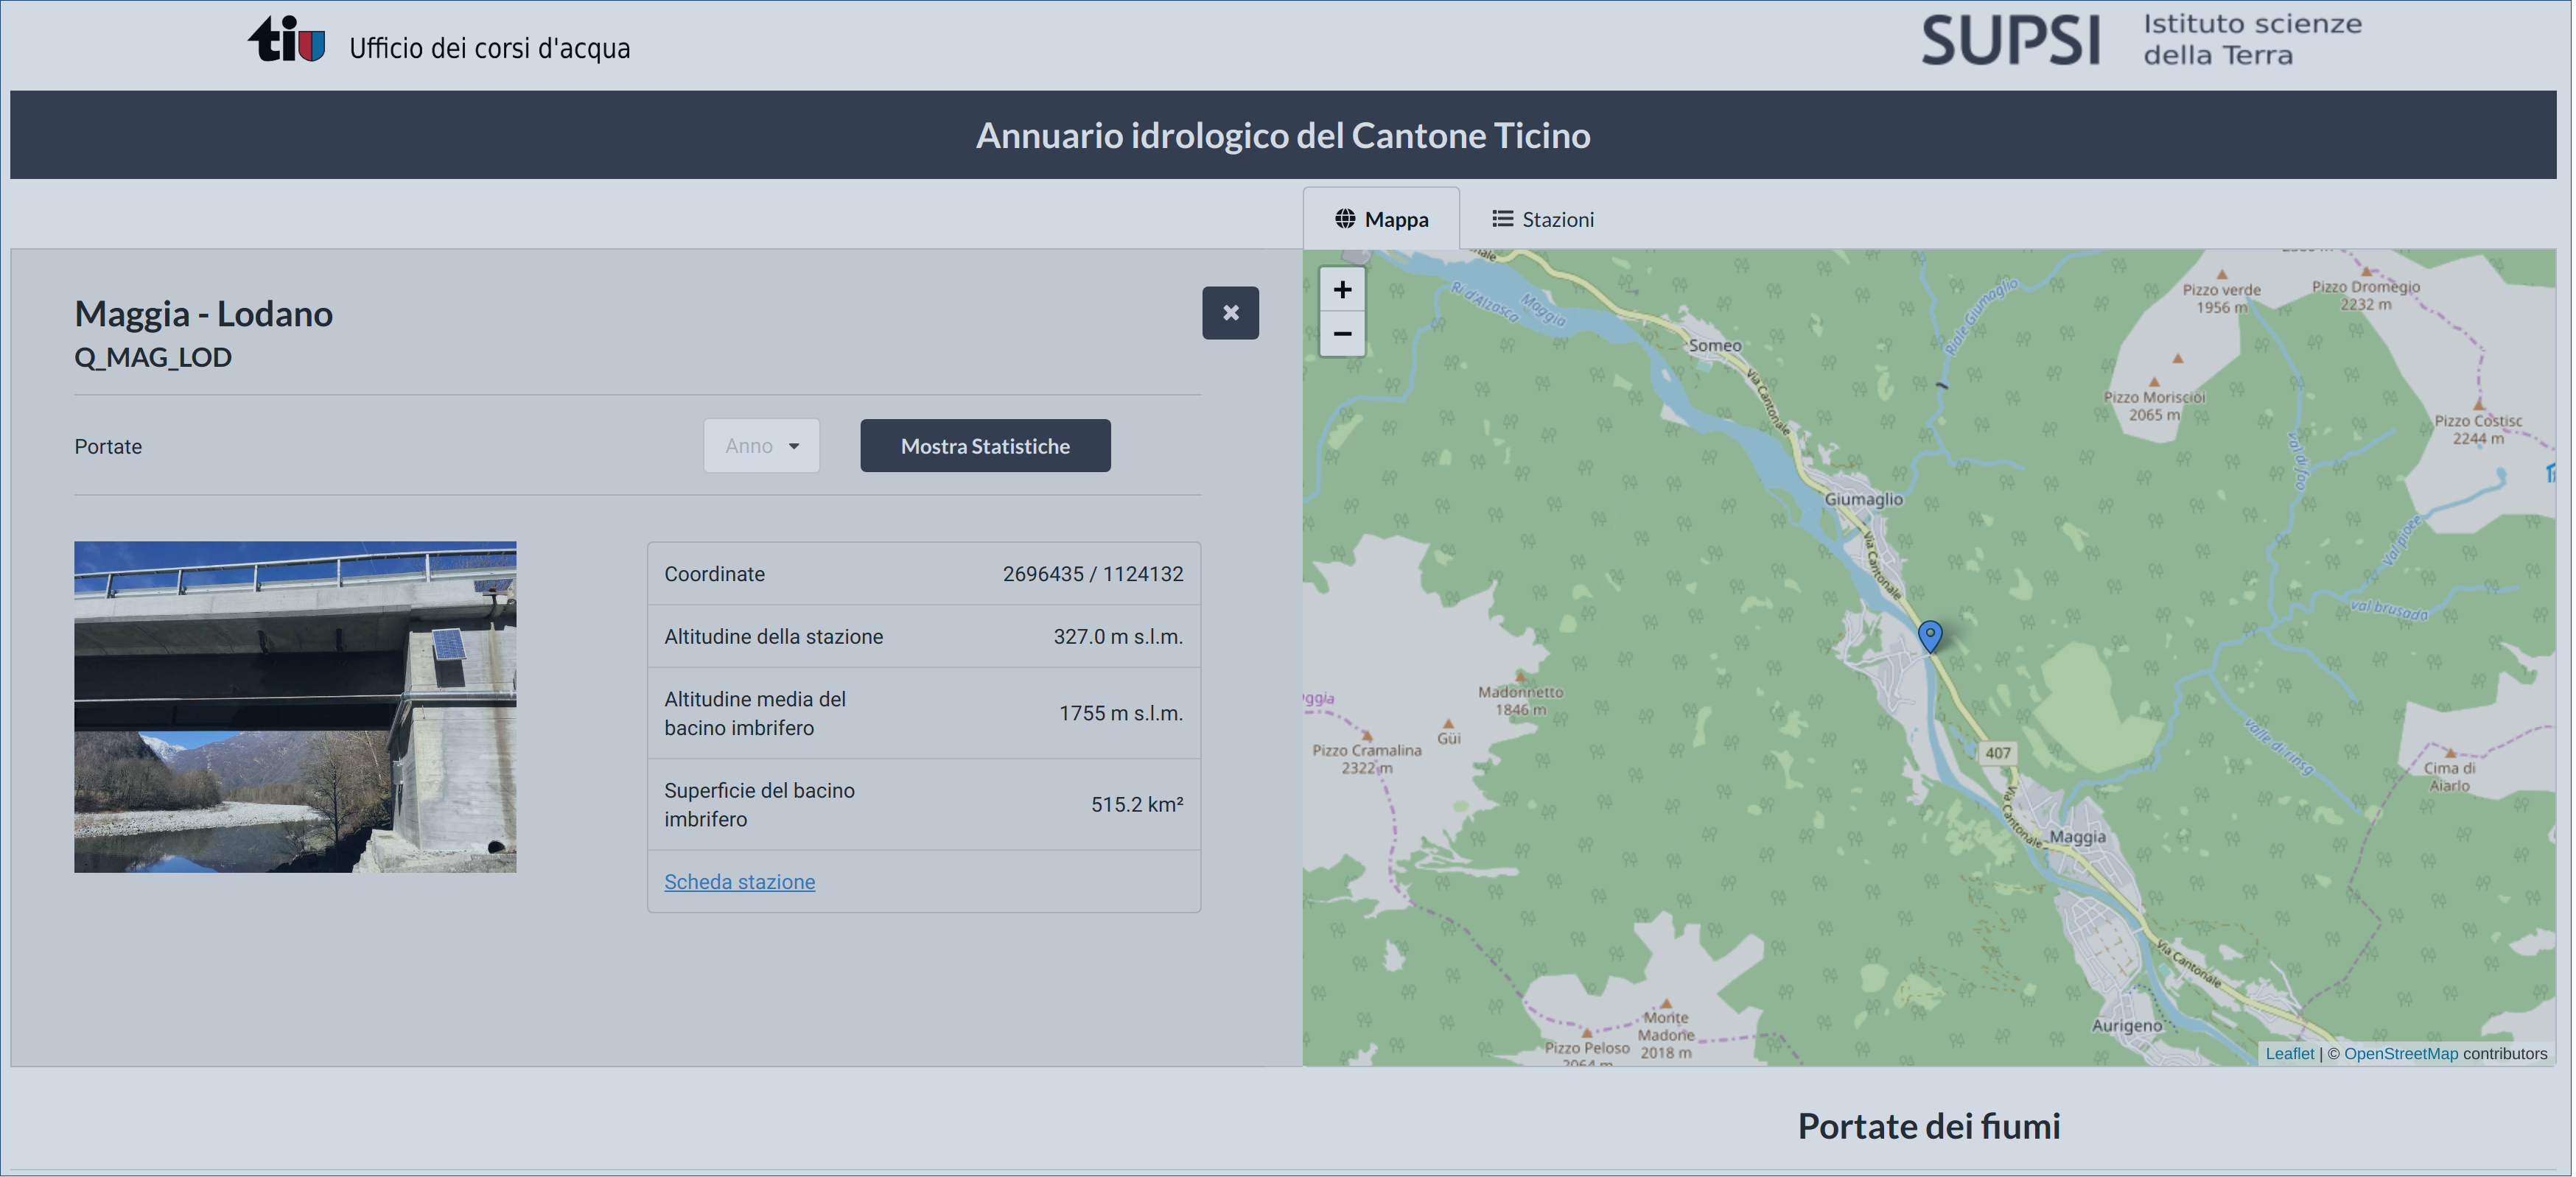

### in a demo instance in istSOS we have the data related to discharges and precipitations in the basin, in this exercise we'll see:
- how to get data
- how to calculate Reference EvapoTranspiration
- how to create SMART model input files
- how to run the model
- how to evaluate the results

### ⚒ As first operation we need to retieve data from the istSOS using OAT

In [ ]:
%load_ext autoreload
%autoreload 2

try:
    from oatlib import sensor, oat_utils, sos2sos, method
except ImportError:
    !pip install oatlib
    from oatlib import sensor, oat_utils, sos2sos, method

try:
    import smartpy
except ImportError:
    !pip install smartpy
    import smartpy

import sys
from datetime import datetime, timezone
import json
import requests
from dateutil import relativedelta
import os


In [ ]:
istsos_url = "http://istsos.org/istsos/demo" # web address of the istSOS server
service = "demo" # service name of the istSOS service
basic_auth = None # Basic Authentication tuple: ("admin", "batman") set to None if no auth required

In [ ]:
event_time = '2019-01-01T01:00:00+0100/2020-01-01T00:00:00+0100'

Q_MAG_LOD = sensor.Sensor.from_istsos_with_ts(
    service =istsos_url, 
    procedure='Q_MAG_LOD',
    observed_property='water:discharge',
    event_time=event_time,
    #aggregate_function='AVG',
    #aggregate_interval='PT10M',
    basic_auth=None, 
    srid=4326,
    #delta=relativedelta.relativedelta(days=15)
)

P_CAV = sensor.Sensor.from_istsos_with_ts(
    service =istsos_url, 
    procedure='P_CAV',
    observed_property='air:rainfall',
    event_time=event_time,
    #aggregate_function='AVG',
    #aggregate_interval='PT10M',
    basic_auth=None, 
    srid=4326,
    #delta=relativedelta.relativedelta(days=15)
)

T_CAV = sensor.Sensor.from_istsos_with_ts(
    service =istsos_url, 
    procedure='T_CAV',
    observed_property='air:temperature',
    event_time=event_time,
    #aggregate_function='AVG',
    #aggregate_interval='PT10M',
    basic_auth=None, 
    srid=4326,
    #delta=relativedelta.relativedelta(days=15)
)

In [ ]:
Q_MAG_LOD.ts['data'].plot(figsize=(20,5),subplots=True,color='navy',title='discharge [m/s]')
P_CAV.ts['data'].plot(figsize=(20,5),subplots=True,color='blue',title='precipitation [m/s]')
T_CAV.ts['data'].plot(figsize=(20,5),subplots=True,color='red',title='temperature [m/s]')

### ⚒ Now we need to calculate ETP

We will use the OATlib method HargreavesETo

In [ ]:
# Calculating the ETP that result in daily values
ETP_CAV = T_CAV.process(method.HargreavesETo())
ETP_CAV.ts['data'].plot(figsize=(20,5),subplots=True,color='red',title='daily ETP [mm/d]')

In [ ]:
# resample at hourly frequency using constant values
ETP_CAV_H = ETP_CAV.process(method.Resample(freq='1H',how='mean',fill='bfill',how_quality='max'))
ETP_CAV_H.ts['data'] = ETP_CAV_H.ts['data']/24
print(ETP_CAV_H.ts.head())

### ⚒ The following step is to create the input files for SmartPy (https://github.com/ThibHlln/smartpy)

SMARTpy is an open-source hydrological catchment model in Python. It is licensed under GNU GPL-3.0 (see licence file provided). SMART (Soil Moisture Accounting and Routing for Transport) is a top-down rainfall-runoff model composed of a soil moisture accounting component and linear routing components. It requires rainfall and potential evapotranspiration time series as inputs, it features a set of ten parameters, and it yields a discharge time series.

The structure of the root directory should follow the pattern described in the following schematic (where 'catchment' can be replaced by the actual name of the catchment):

    root/
        in/
            catchment/
                catchment.rain
                catchment.peva
                catchment.flow
                catchment.parameters
        out/
        
for this we can use a function to create the directories        

In [ ]:
import os
def make_smartpy_dirs(path, catchment, root='smartpy_data'):
    myroot = os.path.join(path, root)
    in_f = os.path.join(myroot, 'in')
    out_f = os.path.join(myroot, 'out')
    in_fc = os.path.join(in_f, catchment)
    out_fc = os.path.join(out_f, catchment)
    for di in [myroot, in_f, in_fc, out_f, out_fc]:
        try:
            if not os.path.exists(di):
                os.mkdir(di)
        except OSError:
            print ("Creation of the directory %s failed" % di)
            for d in [in_fc, in_f, out_fc, out_f, myroot]:
                os.rmdir(d) 
    return in_fc, out_fc, myroot

In [ ]:
# define the name of the directory to be created
path = os.getcwd()

# the name of the catchment
catchment = "maggia"

# create smartpy data structure
inf,outf,root = make_smartpy_dirs(path,catchment)

print('FILE  INPUT PATH: ', inf)
print('FILE OUTPUT PATH: ', outf)
print('SMARTpy ROOT:     ', root)

It's time to create the input files from OAT.Sensor objects:

    Q_MAG_LOD  --> root/in/maggia/maggia.flow
    P_CAV      --> root/in/maggia/maggia.rain
    ETP_CAV_H  --> root/in/maggia/maggia.peva

In [ ]:
Q_MAG_LOD.save_to_csv(
    os.path.join(inf,'maggia.flow'), 
    columns=['data'],
    header=['flow'],
    index_label='DateTime',
    date_format='%Y-%m-%d %H:%M:%S'
)

P_CAV.save_to_csv(
    os.path.join(inf,'maggia.rain'), 
    columns=['data'],
    header=['rain'],
    index_label='DateTime',
    date_format='%Y-%m-%d %H:%M:%S'
)

ETP_CAV_H.save_to_csv(
    os.path.join(inf,'maggia.peva'), 
    columns=['data'],
    header=['peva'],
    index_label='DateTime',
    date_format='%Y-%m-%d %H:%M:%S'
)

In [ ]:
print(path)

In [ ]:
# CRAETE THE MODEL OBJECT
from datetime import datetime, timedelta

sm = smartpy.SMART(
    catchment = catchment, 
    catchment_area_m2 = 515.12e6, 
    start = datetime.strptime('2019/01/03 00:00:00', '%Y/%m/%d %H:%M:%S'), 
    end = datetime.strptime('2019/12/31 00:00:00', '%Y/%m/%d %H:%M:%S'), 
    time_delta_simu = timedelta(hours=1), 
    time_delta_save = timedelta(days=1), 
    warm_up_days = 60, 
    in_format = 'csv',
    out_format = 'csv',
    root = root,
    gauged_area_m2 = 515.12e6
)


In [ ]:
sm.parameters.set_parameters_with_dict(
    {
        'T': 1.0,
        'C': 1.0,
        'H': 0.20845,
        'D': 0.24606,
        'S': 0.0001230,
        'Z': 105.26,
        'SK': 46.82,
        'FK': 315.55,
        'GK': 1066.73,
        'RK': 10.64
    }
)

In [ ]:
simulation_ = sm.simulate(sm.parameters.values)

In [ ]:
evaluation_ = sm.get_evaluation_array()
simulation_ = sm.get_simulation_array()
sm.write_output_files(which='both')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(evaluation_, label='Eval')
plt.plot(simulation_, label='Simul')
plt.legend()

evaluation_ = sm.get_evaluation_array()
simulation_ = sm.get_simulation_array()

import numpy as np

evaluation = evaluation_[~np.isnan(evaluation_)]
simulation = simulation_[~np.isnan(evaluation_)]


from hydroeval import *

nse_ = evaluator(nse, simulation, evaluation)  # calculates the Nash-Sutcliffe efficiency
kge_ = evaluator(kge, simulation, evaluation)  # calculates the original Kling-Gupta efficiency
